In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import numpy as np
import pandas as pd
import seaborn as sns

# Tutorials for this code

Build a Deep Audio Classifier with Python and Tensorflow<br>
https://www.youtube.com/watch?v=ZLIPkmmDJAc<br>
https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb<br>
https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing<br>

Simple audio recognition: Recognizing keywords<br>
https://www.tensorflow.org/tutorials/audio/simple_audio

In [2]:
#define paths to files
RUSSIAN_FILE = os.path.join('data', 'wav', 'russian', 'russian1_male_nizhni_novgorod_russia.wav')
ENGLISH_FILE = os.path.join('data', 'wav', 'english', 'english1_male_pittsburgh_pennsylvania_usa.wav')

In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# Tensforflow Datasets

In [4]:
RUSSIAN = os.path.join('data', 'wav', 'russian')
ENGLISH = os.path.join('data','wav', 'english')

In [5]:
pos = tf.data.Dataset.list_files(RUSSIAN+'/*.wav')
neg = tf.data.Dataset.list_files(ENGLISH+'/*.wav')

2022-11-23 22:15:29.099426: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-23 22:15:29.100041: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

In [7]:
data = positives.concatenate(negatives)

In [8]:
len(data)

151

In [9]:
def calculate_duration(lang):
    lengths = []
    for file in os.listdir(os.path.join('data', 'wav', lang)):
        tensor_wave = load_wav_16k_mono(os.path.join('data', 'wav', lang, file))
        lengths.append(len(tensor_wave))
    return lengths

In [10]:
lengths_russian = calculate_duration('russian')
lengths_english = calculate_duration('english')

2022-11-23 22:15:29.335879: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


# Mean, Max, Min

In [11]:
df_rus = pd.DataFrame({"russian": lengths_russian})
df_rus['russian_sec'] = df_rus['russian']/16000
df_rus.describe()

,russian,russian_sec
count,8.100000e+01,81.000000
mean,4.731715e+05,29.573221
std,1.419447e+05,8.871547
min,3.023470e+05,18.896687
25%,3.751540e+05,23.447125
50%,4.389320e+05,27.433250
75%,5.346930e+05,33.418312
max,1.058272e+06,66.142000


In [12]:
df_eng = pd.DataFrame({"english": lengths_english})
df_eng['english_sec'] = df_eng['english']/16000
df_eng.describe()

,english,english_sec
count,70.000000,70.000000
mean,382154.014286,23.884626
std,60585.867666,3.786617
min,263368.000000,16.460500
25%,340660.500000,21.291281
50%,379742.000000,23.733875
75%,409988.250000,25.624266
max,575584.000000,35.974000


In [13]:
# def preprocess(file_path, label): 
#     wav = load_wav_16k_mono(file_path)
#     spectrogram = tf.signal.stft(wav, frame_length=150, frame_step=16000)
#     spectrogram = tf.abs(spectrogram)
#     spectrogram = tf.expand_dims(spectrogram, axis=2)
#     return spectrogram, label

In [14]:
max(df_rus['russian'].max(), df_eng['english'].max())

1058272

In [15]:
# EXAMPLE FOR 1 FILE
wav = load_wav_16k_mono(RUSSIAN_FILE)
# TODO change line below for better flexibility
max_duration = max(df_rus['russian'].max(), df_eng['english'].max())
# take the max duration and prepend 0s to max size to make every tensor of the same size
zero_padding = tf.zeros([max_duration] - tf.shape(wav), dtype=tf.float32)
wav = tf.concat([zero_padding, wav],0)
spectrogram = tf.signal.stft(wav, frame_length=150, frame_step=16000)
spectrogram = tf.abs(spectrogram)
print(spectrogram.shape)
spectrogram = tf.expand_dims(spectrogram, axis=2)
#^adds information for channel
# Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
print(spectrogram.shape)

(67, 129)
(67, 129, 1)


In [16]:
# example with padding
def preprocess_with_padding(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    # TODO change line below for better flexibility
    max_duration = max(df_rus['russian'].max(), df_eng['english'].max())
    # take the max duration and prepend 0s to max size to make every tensor of the same size
    zero_padding = tf.zeros([max_duration] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=150, frame_step=16000)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [17]:
def show_spectogram(data):
    filepath, label = data.shuffle(buffer_size=10000).as_numpy_iterator().next()
    spectrogram, label = preprocess_with_padding(filepath, label)
    plt.figure(figsize=(10,10))
    plt.imshow(tf.transpose(spectrogram)[0])
    plt.show()

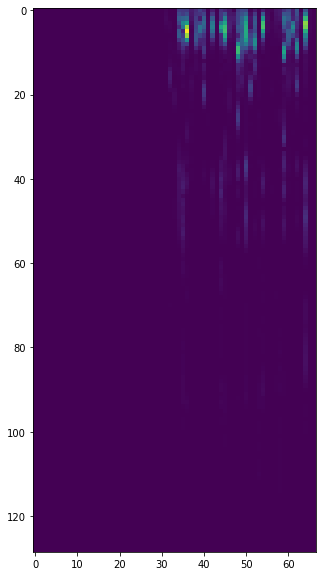

In [18]:
show_spectogram(positives)

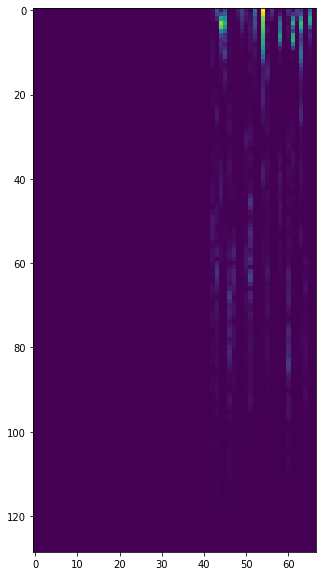

In [19]:
show_spectogram(negatives)

In [20]:
# example with padding

def preprocess_with_padding(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    # TODO change line below for better flexibility
    max_duration = max(df_rus['russian'].max(), df_eng['english'].max())
    # take the max duration and prepend 0s to max size to make every tensor of the same size
    zero_padding = tf.zeros([max_duration] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=150, frame_step=16000)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [21]:
data = positives.concatenate(negatives)
data = data.map(preprocess_with_padding)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [22]:
len(data)

10

In [95]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1, "split ratios must add up to 1"
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    
    assert (train_size + val_size + test_size == ds_size), "split sizes must add up to data size"
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size).take(test_size)
    
    return train_ds, val_ds, test_ds

In [96]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data, len(data))

In [98]:
samples,labels = train_ds.as_numpy_iterator().next()

In [99]:
samples.shape

(16, 67, 129, 1)

In [100]:
input_shape=samples.shape[1:]
input_shape

(67, 129, 1)

# Modeling

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [102]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_shape))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [103]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [104]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 65, 127, 16)       160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 125, 16)       2320      
_________________________________________________________________
flatten (Flatten)            (None, 126000)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16128128  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 16,130,737
Trainable params: 16,130,737
Non-trainable params: 0
_________________________________________________________________


In [105]:
hist = model.fit(train_ds, epochs=4, validation_data=val_ds)

Epoch 1/4
8/8 [==============================] - 3s 211ms/step - loss: 0.9583 - recall: 0.5842 - precision: 0.6022 - val_loss: 0.4963 - val_recall: 0.7778 - val_precision: 0.8750
Epoch 2/4
8/8 [==============================] - 1s 148ms/step - loss: 0.5723 - recall: 0.9451 - precision: 0.6877 - val_loss: 0.4972 - val_recall: 1.0000 - val_precision: 0.7500
Epoch 3/4
8/8 [==============================] - 1s 156ms/step - loss: 0.4946 - recall: 0.9211 - precision: 0.7257 - val_loss: 0.4553 - val_recall: 0.4286 - val_precision: 0.7500
Epoch 4/4
8/8 [==============================] - 1s 145ms/step - loss: 0.3407 - recall: 0.7669 - precision: 0.9577 - val_loss: 0.3003 - val_recall: 1.0000 - val_precision: 0.7143


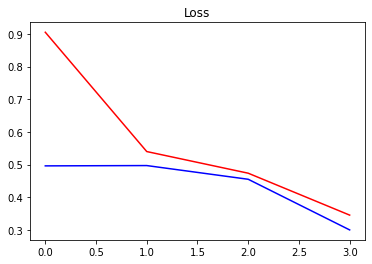

In [107]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

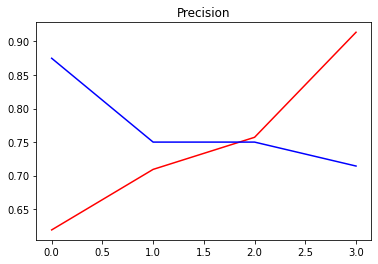

In [108]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

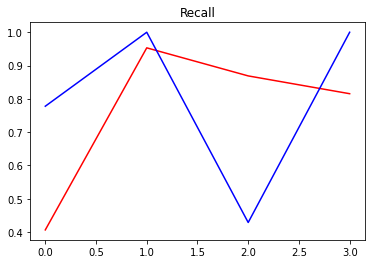

In [109]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [110]:
model.evaluate(test_ds, return_dict=True)

1/1 [==============================] - 0s 72ms/step - loss: 0.3226 - recall: 1.0000 - precision: 0.8571


{'loss': 0.3225891888141632, 'recall': 1.0, 'precision': 0.8571428656578064}

In [118]:
# problem test_ds is TakeDataset object and iterable, so if running multiple times -> goes through each batch
# if running several times, y_pred and y_true might not coinside 
# not sure how to get back the whole dataset instead of SkipDataset
# possible solns - https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets
type(test_ds)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [114]:
# on single batch
X_test, y_test = test_ds.as_numpy_iterator().next()
yhat = model.predict(X_test)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
print(yhat)
yhat == y_test

[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]


array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [119]:
# y_pred = model.predict(test_ds)
# print(y_pred)
# y_pred = [1. if prediction > 0.5 else 0. for prediction in y_pred]

In [120]:
# y_true = tf.concat(list(test_ds.map(lambda s,lab: lab)), axis=0)
# y_true 

In [123]:
# confusion_mtx = tf.math.confusion_matrix(tf.concat(list(test_ds.map(lambda s,lab: lab)), axis=0), model.predict(test_ds))
# plt.figure(figsize=(10, 8))
# sns.heatmap(confusion_mtx,
# #             xticklabels=commands,
# #             yticklabels=commands,
#             annot=True, fmt='g')
# plt.xlabel('Prediction')
# plt.ylabel('Label')
# plt.show()

In [125]:
# tf.data.experimental.get_single_element(test_ds)

In [ ]:
# y_preds = []
# while itx, ity := test_ds.as_numpy_iterator().next():
#     for X_test in ity:
#         print(X_test)
# #         y_pred = model.predict(X_test)
# #         y_preds.extend(y_pred)